## Demonstration of System Identification using Gradient Descent

This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Data-Driven Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).

This notebook illustrates the application of the gradient descent algorithm to system identification. Here the impulse response of an linear time-invariant (LTI) system is estimated from given input and output signal of the system. The problem is formulated as multivariate linear regression problem which is solved iteratively by gradient descent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.model_selection import train_test_split

np.random.seed(42)

### Generate Dataset

The dataset is generated by computing the output signal by convolving the input signal with the impulse response and adding normal distribute noise.

In [2]:
N = 1000  # total number of examples
F = 256  # number of features (=length of impuse response)


def generate_dataset(s, h, N, F):

    # normalize input signal
    s = s / np.std(s)

    # compute output signal
    Y = np.convolve(s, h, mode='full')
    Y = Y[F:N+F] + .2 * np.random.normal(size=N)

    # construct feature matrix
    X = np.zeros((N, F))
    for n in range(N):
        X[n, :] = s[F+n:n:-1]

    return X, Y

# load samples from speech file
s, fs = sf.read('../data/speech.wav')

# generate true impulse response
h = np.zeros(F)
h[:32] = np.blackman(32)

X, Y = generate_dataset(s, h, N, F)

### Estimate Impulse Response

The impulse response of the LTI system is estimated by applying the mini-batch regularized gradient descent algorithm to the multivariate regression problem. First functions are defined which implement the gradient descent algorithm

In [3]:
def split_array(a, size):
    return np.split(a, np.arange(size, len(a), size))


def mini_batch_gradient_descent(X, Y, theta_0, gradient, lr=0.01, mu=1e-10, max_iter=100, batch=32):

    N = X.shape[0]
    theta_min = theta_0.copy()
    n_batch = int(np.ceil(N/batch))
    n_epoch = int(np.ceil(max_iter/n_batch))
    indices = np.arange(N)

    history = list()
    history.append(theta_0.copy())

    for epoch in range(n_epoch):
        Xb = split_array(X[indices, :], batch)
        Yb = split_array(Y[indices], batch)
        np.random.shuffle(indices)

        for b in range(n_batch):
            theta_min -= lr/batch * gradient(theta_min, Xb[b], Yb[b], mu)
            history.append(theta_min.copy())

    return np.array(history)


def gradient(theta, X, Y, mu):
    return - 2*(X.T @ Y) + 2*(X.T @ X) @ theta + mu * theta


def predict(X, theta):
    return np.dot(X, theta)

In order to illustrate the effect of regularization on the convergence and the generalisation

1. the dataset is split into and training and validation subsets,
2. the impulse response of the system is estimated using the training subset, and
3. validation is performed at each iteration using the validation subset.

The mean-squared error (MSE) between the estimated and the true output of the system is used as validation measure. The procedure is performed for two different scenarios, without and with regularization.

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

theta_0 = np.zeros(F)
lr = 1e-1
batch = 32
max_iter=50000

history1 = mini_batch_gradient_descent(X_train, Y_train, theta_0, gradient, lr=lr, mu=0, max_iter=max_iter, batch=batch)
history2 = mini_batch_gradient_descent(X_train, Y_train, theta_0, gradient, lr=lr, mu=5, max_iter=max_iter, batch=batch)

MSE_train1 = [np.linalg.norm(Y_train - predict(X_train,histn))**2 for histn in history1]
MSE_test1 = [np.linalg.norm(Y_test - predict(X_test,histn))**2 for histn in history1]

MSE_train2 = [np.linalg.norm(Y_train - predict(X_train,histn))**2 for histn in history2]
MSE_test2 = [np.linalg.norm(Y_test - predict(X_test,histn))**2 for histn in history2]

Lets compare the MSE of the four different cases by plotting their evolution over the iterations. The effect of the regularization on the generalization performance is clearly visible.

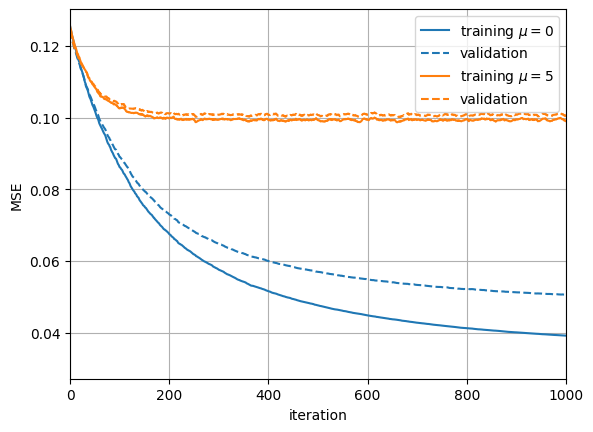

In [5]:
plt.plot(1/len(Y_train) * np.array(MSE_train1), label=r'training $\mu = 0$', color='C0', linestyle='-')
plt.plot(1/len(Y_test) * np.array(MSE_test1), label=r'validation', color='C0', linestyle='--')
plt.plot(1/len(Y_train) * np.array(MSE_train2), label=r'training $\mu = 5$', color='C1', linestyle='-')
plt.plot(1/len(Y_test) * np.array(MSE_test2), label=r'validation', color='C1', linestyle='--')

plt.xlabel('iteration')
plt.ylabel('MSE')
plt.xlim([0, 1000])
plt.legend()
plt.grid()

The estimated impulse response is plotted in the following.

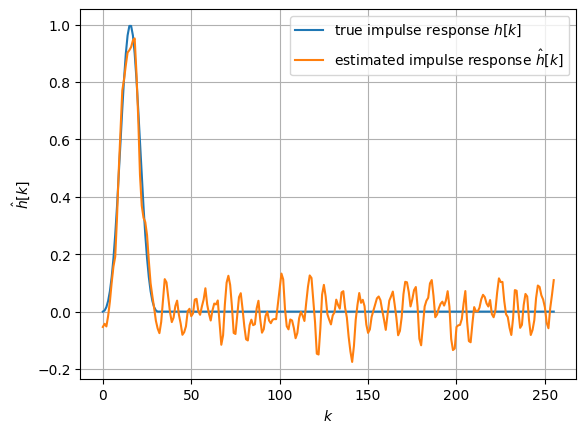

In [6]:
plt.plot(h, label=r'true impulse response $h[k]$')
plt.plot(history1[5000,:], label=r'estimated impulse response $\hat{h}[k]$')

plt.xlabel(r'$k$')
plt.ylabel(r'$\hat{h}[k]$')
plt.grid()
plt.legend()

**Copyright**

This notebook is provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources).
The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)
, the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: Sascha Spors, Data driven audio signal processing - Lecture supplementals.